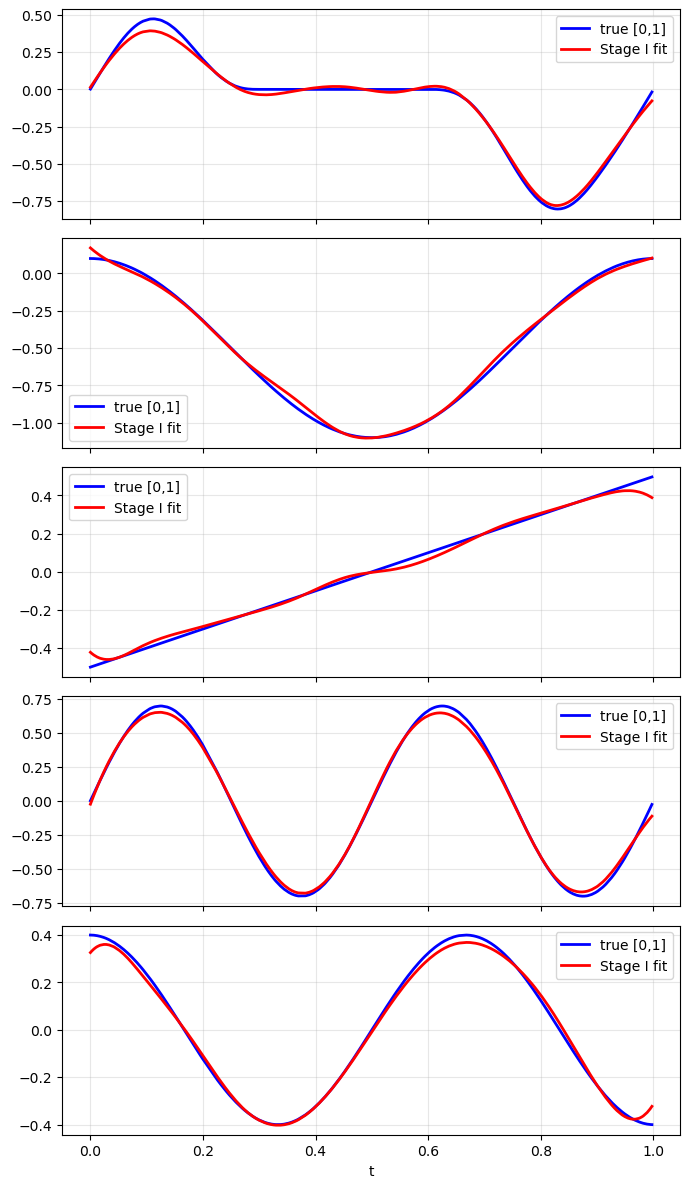

[Stage I] m1=14, λ1*=5.012e-01


In [10]:
# ============================ 阶段 I：在 [0,1] 上训练 + 可视化 ============================
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import norm
from scipy.interpolate import BSpline

# ---------- 工具 ----------
def ghost_mask(u, a=0.3, b=0.6):
    """
    C^2 平滑掩码：在 [a,b] 内严格为 0；区间外从 0 平滑升至 1（不过冲）。
    过渡带宽自适应（统一尺度），且可通过 ALPHA 在全局控制“陡/缓”。
      - ALPHA 越大 → 过渡越宽、越“慢”；建议 0.10 ~ 0.30 之间。
      - 函数签名不变，可直接替换原实现。
    """
    u = np.asarray(u, dtype=float)
    if a > b: a, b = b, a

    # —— 全局平滑参数（可按需要改一个数字即可）——
    ALPHA = 0.30                        # ← 想更“缓”就调大：0.20→0.25→0.30
    Uspan = np.ptp(u) if np.ptp(u) > 0 else 1.0
    delta = ALPHA * Uspan               # 统一尺度的过渡宽度

    # quintic smoothstep（C^2），比 exp(-1/t) 温和很多
    def s(x):
        x = np.clip(x, 0.0, 1.0)
        return x*x*x*(x*(x*6 - 15) + 10)   # 6x^5 - 15x^4 + 10x^3

    # 到区间 [a,b] 的距离（区间内为 0，区间外为 >0）
    t = np.maximum(0.0, np.maximum(a - u, u - b))

    # 先定义一个从 0（在区间内）到 1（远离区间）的“距离映射”
    #   t/delta ∈ [0, +∞)，经 smoothstep 压到 [0,1]，并在 t≥delta 后基本饱和到 1
    ramp = s(t / (delta + 1e-12))

    # ramp=0 处即 [a,b]，严格 0；过渡区宽约 delta；区间外逐渐趋近 1
    return ramp

def make_open_uniform_knots(a, b, k, n_inner):
    inner = np.linspace(a, b, n_inner+2)[1:-1] if n_inner>0 else np.array([])
    return np.r_[np.repeat(a, k+1), inner, np.repeat(b, k+1)]

def bspline_design_matrix(x, knots, k):
    m = len(knots) - (k+1)
    B = np.zeros((len(x), m))
    for j in range(m):
        c = np.zeros(m); c[j]=1.0
        B[:, j] = BSpline(knots, c, k, extrapolate=False)(x)
    B[np.isnan(B)] = 0.0
    return B

def build_vcm_design(B, X):
    n, m = B.shape; P = X.shape[1]
    out = np.zeros((n, m*P))
    for p in range(P): out[:, p*m:(p+1)*m] = X[:, [p]] * B
    return out

def split_blocks(vec, m, P): return [vec[p*m:(p+1)*m] for p in range(P)]

def gram_R(knots, k, a, b, grid=2500):
    gx = np.linspace(a, b, grid)
    B = bspline_design_matrix(gx, knots, k)
    w = np.ones(grid); w[0]*=0.5; w[-1]*=0.5; w *= (b-a)/(grid-1)
    return B.T @ (B * w[:,None])

def group_weights(B, X):
    row_e = np.sum(B*B, axis=1)
    return np.sqrt((X**2 * row_e[:,None]).sum(0)/B.shape[0] + 1e-12)

def lambda_max_R(XtB, y, m, R):
    L = np.linalg.cholesky(R); P = XtB.shape[1]//m; lam = 0.0
    for p in range(P):
        g = XtB[:, p*m:(p+1)*m].T @ y
        u = np.linalg.solve(L.T, g)
        lam = max(lam, float(norm(u)))
    return lam

def group_soft_thresh(blocks, tau, R, lam, w):
    out=[]
    for v,wp in zip(blocks,w):
        nr=float(np.sqrt(max(0.0, v.T@R@v))); thr=tau*lam*wp
        out.append(np.zeros_like(v) if nr<=thr else (1-thr/nr)*v)
    return out

def fista_group_lasso(XtX, Xty, lam, m, P, R, w, max_iter=3000, tol=1e-6):
    d=m*P; Ls=float(np.linalg.norm(XtX,2)); Ls = Ls if (np.isfinite(Ls) and Ls>0) else 1.0
    step=1.0/Ls; c=np.zeros(d); z=c.copy(); tN=1.0
    for _ in range(max_iter):
        grad= XtX@z - Xty
        yv  = z - step*grad
        yb  = split_blocks(yv, m, P)
        c_new = np.concatenate(group_soft_thresh(yb, step, R, lam, w))
        t_new = 0.5*(1+np.sqrt(1+4*tN*tN))
        z = c_new + (tN-1)/t_new*(c_new-c)
        if norm(c_new-c) <= tol*max(1.0, norm(c)): return c_new
        c, tN = c_new, t_new
    return c

def kfold_indices(n,K=5,seed=0):
    rng=np.random.default_rng(seed); idx=np.arange(n); rng.shuffle(idx)
    return np.array_split(idx,K)

def cv_select_lambda(B,X,y,R,w,lams,K=5,seed=2025,use_1se=True):
    n,m=B.shape; P=X.shape[1]; folds=kfold_indices(n,K,seed)
    mse=np.zeros((len(lams),K))
    for li,lam in enumerate(lams):
        for kf,val in enumerate(folds):
            tr=np.setdiff1d(np.arange(n),val)
            Btr,Bv=B[tr],B[val]; Xtr,Xv=X[tr],X[val]; ytr,yv=y[tr],y[val]
            XtBtr=build_vcm_design(Btr,Xtr); XtBv=build_vcm_design(Bv,Xv)
            XtX=XtBtr.T@XtBtr; Xty=XtBtr.T@ytr
            c=fista_group_lasso(XtX,Xty,lam,m,P,R,w)
            mse[li,kf]=np.mean((yv - XtBv@c)**2)
    mm=mse.mean(1); best=int(np.argmin(mm))
    if use_1se:
        se=mse.std(1,ddof=1)/np.sqrt(K); thr=mm[best]+se[best]
        best=int(np.where(mm<=thr)[0][0])
    return float(lams[best]), mm, mse

# ---------- 真函数与数据 ----------
def true_funcs():
    return [
        lambda u: np.sin(2*np.pi*u)*ghost_mask(u,0.3,0.6),
        lambda u: -0.5+0.6*np.cos(2*np.pi*u),
        lambda u: (u-0.5),
        lambda u: 0.7*np.sin(4*np.pi*u),
        lambda u: 0.4*np.cos(3*np.pi*u),
    ]

def gen_interval(funcs,a,b,n,P,signal_idx,sigma,seed):
    rng=np.random.default_rng(seed)
    t=np.sort(rng.uniform(a,b,n))
    X=rng.standard_normal((n,P)); X=(X-X.mean(0))/(X.std(0)+1e-12)
    beta=np.zeros((n,P))
    for j,idx in enumerate(signal_idx):
        beta[:,idx]=funcs[j%len(funcs)](t)
    y=(X*beta).sum(1)+sigma*rng.standard_normal(n)
    return t,X,y,beta

# ---------- 阶段 I ----------
# 超参
k=3; n_inner=10; P=100; n=400; noise_sigma=0.1; seed_data=0; seed_cv=2025; use_1se=True
signal_idx=[1,2,3,4,5]

funcs=true_funcs()
t1,X1,y1,beta1=gen_interval(funcs,0,1,n,P,signal_idx,noise_sigma,seed_data)
knots1 = make_open_uniform_knots(0.0,1.0,k,n_inner)          # 0/1 端点各重复 k+1 次
B1     = bspline_design_matrix(t1, knots1, k); m1=B1.shape[1]
XBt1   = build_vcm_design(B1, X1)
R1     = gram_R(knots1, k, 0.0, 1.0)
w1     = group_weights(B1, X1)
lammax = lambda_max_R(XBt1, y1, m1, R1)
lams   = np.geomspace(lammax, lammax*5e-4, 30)

lam1,_,_ = cv_select_lambda(B1, X1, y1, R1, w1, lams, K=5, seed=seed_cv, use_1se=use_1se)
c1 = fista_group_lasso(XBt1.T@XBt1, XBt1.T@y1, lam1, m1, P, R1, w1)
coef1 = split_blocks(c1, m1, P)

# —— 可视化：真值 vs 阶段 I 拟合（前 r 条有效组）——
r = min(len(signal_idx), 5)
betahat1 = np.column_stack([B1 @ coef1[p] for p in range(P)])
order = np.argsort(t1)
fig,axs=plt.subplots(r,1,figsize=(7,1.8*r+3),sharex=True)
for ax,p in zip(axs, signal_idx[:r]):
    ax.plot(t1[order], beta1[order, p], 'b', lw=2, label='true [0,1]')
    ax.plot(t1[order], betahat1[order, p], 'r', lw=2, label='Stage I fit')
    ax.grid(alpha=0.3); ax.legend()
axs[-1].set_xlabel("t"); plt.tight_layout(); plt.show()

print(f"[Stage I] m1={m1}, λ1*={lam1:.3e}")
# —— 阶段二将直接使用：knots1, c1, t1, X1, y1, (以及超参)


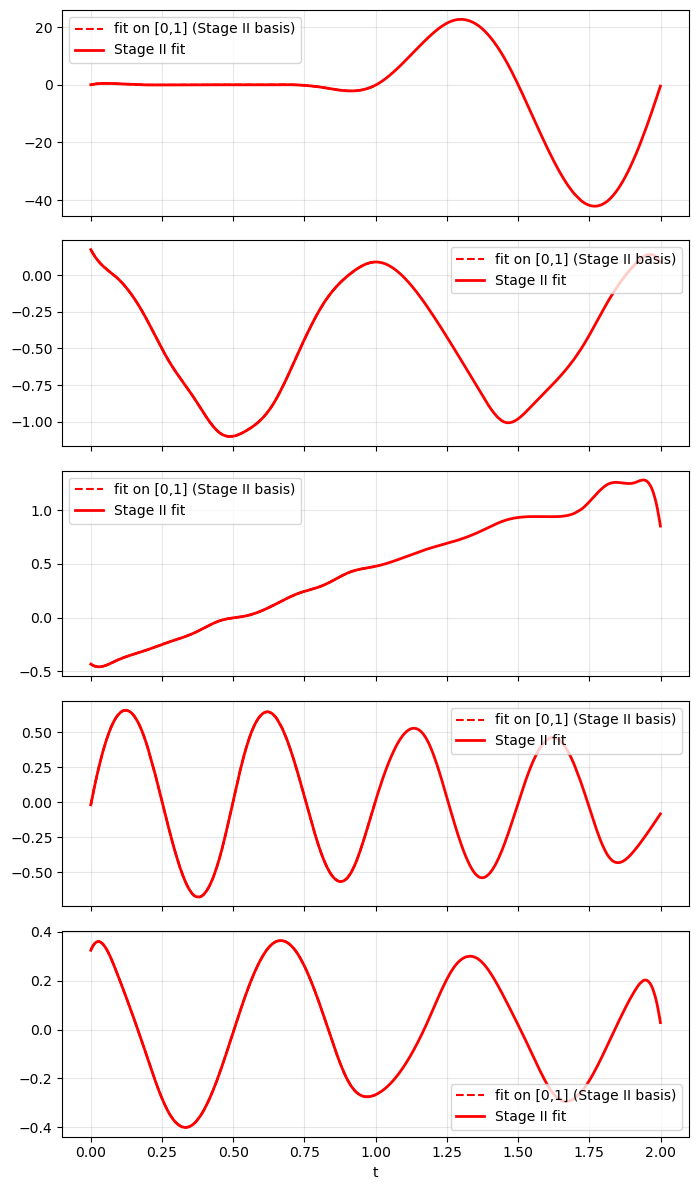

[Stage II] |Go|=10, |Gc∪Gn|=14, λ2*=4.649e+00, Train RMSE=0.1838


In [4]:
# ============================ 阶段 II：从 [0,1] 扩到 [0,2]（含维度对齐修复） ============================
import numpy as np
from numpy.linalg import norm
from scipy.interpolate import BSpline
import matplotlib.pyplot as plt

# —— 需要阶段 I 里已存在：knots1, c1, t1, X1, y1，以及 k, n_inner, P, n, signal_idx, noise_sigma, seed_data, seed_cv, use_1se —— #

# ---------- 复用工具 ----------
def bspline_design_matrix(x, knots, k):
    m = len(knots) - (k+1)
    B = np.zeros((len(x), m))
    for j in range(m):
        c = np.zeros(m); c[j]=1.0
        B[:, j] = BSpline(knots, c, k, extrapolate=False)(x)
    B[np.isnan(B)] = 0.0
    return B

def build_vcm_design(B, X):
    n, m = B.shape; P = X.shape[1]
    out = np.zeros((n, m*P))
    for p in range(P): out[:, p*m:(p+1)*m] = X[:, [p]] * B
    return out

def split_blocks(vec, m, P): return [vec[p*m:(p+1)*m] for p in range(P)]

def gram_R(knots, k, a, b, grid=2500):
    gx = np.linspace(a, b, grid)
    B = bspline_design_matrix(gx, knots, k)
    w = np.ones(grid); w[0]*=0.5; w[-1]*=0.5; w *= (b-a)/(grid-1)
    return B.T @ (B * w[:,None])

def group_weights(B, X):
    row_e = np.sum(B*B, axis=1)
    return np.sqrt((X**2 * row_e[:,None]).sum(0)/B.shape[0] + 1e-12)

def lambda_max_R(XtB, y, m, R):
    L = np.linalg.cholesky(R); P = XtB.shape[1]//m; lam=0.0
    for p in range(P):
        g = XtB[:, p*m:(p+1)*m].T @ y
        u = np.linalg.solve(L.T, g); lam=max(lam, float(norm(u)))
    return lam

def group_soft_thresh(blocks, tau, R, lam, w):
    out=[]
    for v,wp in zip(blocks,w):
        nr=float(np.sqrt(max(0.0, v.T@R@v))); thr=tau*lam*wp
        out.append(np.zeros_like(v) if nr<=thr else (1-thr/nr)*v)
    return out

def fista_group_lasso(XtX, Xty, lam, m, P, R, w, max_iter=3000, tol=1e-6):
    d=m*P; Ls=float(np.linalg.norm(XtX,2)); Ls=Ls if (np.isfinite(Ls) and Ls>0) else 1.0
    step=1.0/Ls; c=np.zeros(d); z=c.copy(); tN=1.0
    for _ in range(max_iter):
        grad= XtX@z - Xty
        yv  = z - step*grad
        yb  = split_blocks(yv, m, P)
        c_new = np.concatenate(group_soft_thresh(yb, step, R, lam, w))
        t_new = 0.5*(1+np.sqrt(1+4*tN*tN))
        z = c_new + (tN-1)/t_new*(c_new-c)
        if norm(c_new-c) <= tol*max(1.0, norm(c)): return c_new
        c, tN = c_new, t_new
    return c

def kfold_indices(n,K=5,seed=0):
    rng=np.random.default_rng(seed); idx=np.arange(n); rng.shuffle(idx)
    return np.array_split(idx,K)

def cv_select_lambda_frozen(B_full, X, y, R_full, lambdas, idx_o, c_o_mat, K=5, seed=2025, use_1se=True):
    n_all, m2 = B_full.shape; P = X.shape[1]
    folds = kfold_indices(n_all, K, seed)
    idx_cn = np.setdiff1d(np.arange(m2), idx_o)
    mse = np.zeros((len(lambdas), K))
    for li, lam in enumerate(lambdas):
        for kf, val in enumerate(folds):
            tr = np.setdiff1d(np.arange(n_all), val)
            Btr,Bv = B_full[tr], B_full[val]
            Xtr,Xv = X[tr], X[val]
            ytr,yv = y[tr], y[val]
            Btr_o,Bv_o   = Btr[:, idx_o], Bv[:, idx_o]
            Btr_cn,Bv_cn = Btr[:, idx_cn], Bv[:, idx_cn]
            frozen_tr = np.sum(Xtr*(Btr_o@c_o_mat.T), axis=1)
            frozen_v  = np.sum(Xv *(Bv_o @c_o_mat.T), axis=1)
            ytr_res, yv_res = ytr - frozen_tr, yv - frozen_v
            R_cn = R_full[np.ix_(idx_cn, idx_cn)]
            w_cn = group_weights(Btr_cn, Xtr)
            XtBtr=build_vcm_design(Btr_cn, Xtr); XtBv=build_vcm_design(Bv_cn, Xv)
            XtX = XtBtr.T@XtBtr; Xty = XtBtr.T@ytr_res; m_cn=Btr_cn.shape[1]
            c = fista_group_lasso(XtX,Xty,lam,m_cn,P,R_cn,w_cn)
            mse[li,kf]=np.mean((yv - (frozen_v + XtBv@c))**2)
    mm=mse.mean(1); best=int(np.argmin(mm))
    if use_1se:
        se=mse.std(1,ddof=1)/np.sqrt(K); thr=mm[best]+se[best]
        best=int(np.where(mm<=thr)[0][0])
    return float(lambdas[best]), mm, mse

# —— “4 结点匹配”：找出在释放 1 的重复后仍保持不变的旧基（两阶段一一对应）—— #
def map_unchanged_bases_simple(knots1, knots2, k, eps=1e-12):
    t1=np.asarray(knots1); t2=np.asarray(knots2)
    m1=len(t1)-(k+1); m2=len(t2)-(k+1)
    S1=np.stack([t1[j:j+k+1] for j in range(m1)],0)  # (m1, k+1)
    S2=np.stack([t2[j:j+k+1] for j in range(m2)],0)  # (m2, k+1)
    cand1=np.where(S1[:,-1] <= 1.0+eps)[0]
    cand2=np.where(S2[:,-1] <= 1.0+eps)[0]
    pairs=[]  # (i1, i2)
    for i in cand1:
        a=S1[i]
        hit=np.where(np.all(np.abs(S2[cand2]-a)<eps, axis=1))[0]
        if hit.size==1:
            pairs.append((i, int(cand2[hit[0]])))
    if len(pairs)==0:
        return np.array([],int), np.array([],int)
    idx1_keep, idx2_match = zip(*pairs)
    return np.array(idx1_keep,int), np.array(idx2_match,int)

# ---------- 生成 [1,2] 数据 ----------
def true_funcs():
    return [
        lambda u: np.sin(2*np.pi*u)*ghost_mask(u,0.3,0.6)*100,
        lambda u: -0.5+0.6*np.cos(2*np.pi*u),
        lambda u: (u-0.5),
        lambda u: 0.7*np.sin(4*np.pi*u),
        lambda u: 0.4*np.cos(3*np.pi*u),
    ]

def gen_interval(funcs,a,b,n,P,signal_idx,sigma,seed):
    rng=np.random.default_rng(seed)
    t=np.sort(rng.uniform(a,b,n))
    X=rng.standard_normal((n,P)); X=(X-X.mean(0))/(X.std(0)+1e-12)
    beta=np.zeros((n,P))
    for j,idx in enumerate(signal_idx):
        beta[:,idx]=funcs[j%len(funcs)](t)
    y=(X*beta).sum(1)+sigma*rng.standard_normal(n)
    return t,X,y,beta

# ---------- 阶段 II 主流程 ----------
# 1) knots2：仅 0/2 端点重复；1 仅一次（内部结点）
left_inner  = np.linspace(0,1,n_inner+2)[1:-1]
right_inner = np.linspace(1,2,n_inner+2)[1:-1]
knots2 = np.r_[np.repeat(0.0,k+1), left_inner, 1.0, right_inner[1:], np.repeat(2.0,k+1)]

# 2) 一一对应的“可冻结旧基”索引（阶段一 vs 阶段二）
idx1_o_keep, idx2_o_matched = map_unchanged_bases_simple(knots1, knots2, k)

# （可选）边界放宽 r_relax：把最靠近 1 的若干可冻结基也放入可调集合
r_relax = 2
if r_relax>0 and len(idx2_o_matched)>r_relax:
    # 以右端点排序，挑最靠近 1 的 r_relax 个移出 O
    right_end = np.array([knots2[i + k] for i in idx2_o_matched])  # 每个基的右端 = knots2[i+k]
    order = np.argsort(right_end)
    move_mask = np.zeros_like(idx2_o_matched, dtype=bool)
    move_mask[order[-r_relax:]] = True
    # —— 关键修复：O 集与冻结系数需要“同步子集化 + 顺序对齐” —— #
    idx2_o = idx2_o_matched[~move_mask]            # 保留的 O（阶段二列索引，按原顺序）
    idx1_o = idx1_o_keep[~move_mask]               # 对应的阶段一列索引（与 idx2_o 一一对齐）
else:
    idx2_o = idx2_o_matched
    idx1_o = idx1_o_keep

# 3) 数据拼接、基矩阵与切块（注意 O 与 idx1_o/idx2_o 已经一一对应）
funcs = true_funcs()
t2,X2,y2,_ = gen_interval(funcs,1,2,n,P,signal_idx,noise_sigma,seed_data+1)
t_all = np.r_[t1, t2]; X_all = np.vstack([X1, X2]); y_all = np.r_[y1, y2]

B2 = bspline_design_matrix(t_all, knots2, k)
idx2_all = np.arange(B2.shape[1])
idx2_cn  = np.setdiff1d(idx2_all, idx2_o)
B2_o  = B2[:, idx2_o]          # (n_all, |O|)
B2_cn = B2[:, idx2_cn]

# 4) 冻结系数矩阵 (P, |O|) —— 与 idx2_o 的列顺序严格一致
coef1_blocks = split_blocks(c1, len(knots1)-(k+1), P)
c_o_mat = np.stack([coef1_blocks[p][idx1_o].astype(float, copy=True) for p in range(P)], axis=0)  # (P, |O|)

# 5) 冻结贡献（维度现在严格匹配：B2_o@(P,|O|)^T）
def frozen_contrib(B_o, X, c_o): return np.sum(X * (B_o @ c_o.T), axis=1)
frozen_y = frozen_contrib(B2_o, X_all, c_o_mat)
y_res    = y_all - frozen_y

# 6) 子问题：R_cn、权重、λ 路径（都在 cn 子空间）
R2     = gram_R(knots2, k, 0.0, 2.0)
R2_cn  = R2[np.ix_(idx2_cn, idx2_cn)]
w2_cn  = group_weights(B2_cn, X_all)
XtB_cn = build_vcm_design(B2_cn, X_all)
lam2_max = lambda_max_R(XtB_cn, y_res, B2_cn.shape[1], R2_cn)
lams2 = np.geomspace(lam2_max, lam2_max*5e-4, 30)

# 7) 逐折冻结CV 选 λ2，并在 (C∪N) 上求解
lam2, _, _ = cv_select_lambda_frozen(B2, X_all, y_all, R2, lams2, idx_o=idx2_o, c_o_mat=c_o_mat, K=5, seed=seed_cv, use_1se=use_1se)
XtX2 = XtB_cn.T @ XtB_cn; Xty2 = XtB_cn.T @ y_res
c2   = fista_group_lasso(XtX2, Xty2, lam2, B2_cn.shape[1], P, R2_cn, w2_cn)

# 8) 拼回完整系数并可视化（对前 r 个有效组）
blocks_cn = split_blocks(c2, B2_cn.shape[1], P)
coef2=[]
for p in range(P):
    c_full = np.zeros(B2.shape[1])
    c_full[idx2_o]  = c_o_mat[p]
    c_full[idx2_cn] = blocks_cn[p]
    coef2.append(c_full)

# 可视化：真值 vs 阶段 II 拟合
r = min(len(signal_idx), 5)
B_eval = bspline_design_matrix(t_all, knots2, k)
betahat2 = np.column_stack([B_eval @ coef2[p] for p in range(P)])
order = np.argsort(t_all)
fig,axs=plt.subplots(r,1,figsize=(7,1.8*r+3),sharex=True)
for ax,p in zip(axs, signal_idx[:r]):
    ax.plot(t1, betahat2[:len(t1), p], 'r--', lw=1.5, label='fit on [0,1] (Stage II basis)')
    ax.plot(t1, betahat2[:len(t1), p], 'r--', alpha=0)  # 只占位
    ax.plot(t1, betahat2[:len(t1), p], 'r--')           # 上面两行用于兼容某些后端
    ax.plot(t_all[order], betahat2[order, p], 'r', lw=2, label='Stage II fit')
    ax.grid(alpha=0.3); ax.legend()
axs[-1].set_xlabel("t"); plt.tight_layout(); plt.show()

# 训练 RMSE（全量）
yhat_all = frozen_y + build_vcm_design(B2_cn, X_all) @ c2
rmse_all = float(np.sqrt(np.mean((y_all - yhat_all)**2)))
print(f"[Stage II] |Go|={len(idx2_o)}, |Gc∪Gn|={len(idx2_cn)}, λ2*={lam2:.3e}, Train RMSE={rmse_all:.4f}")


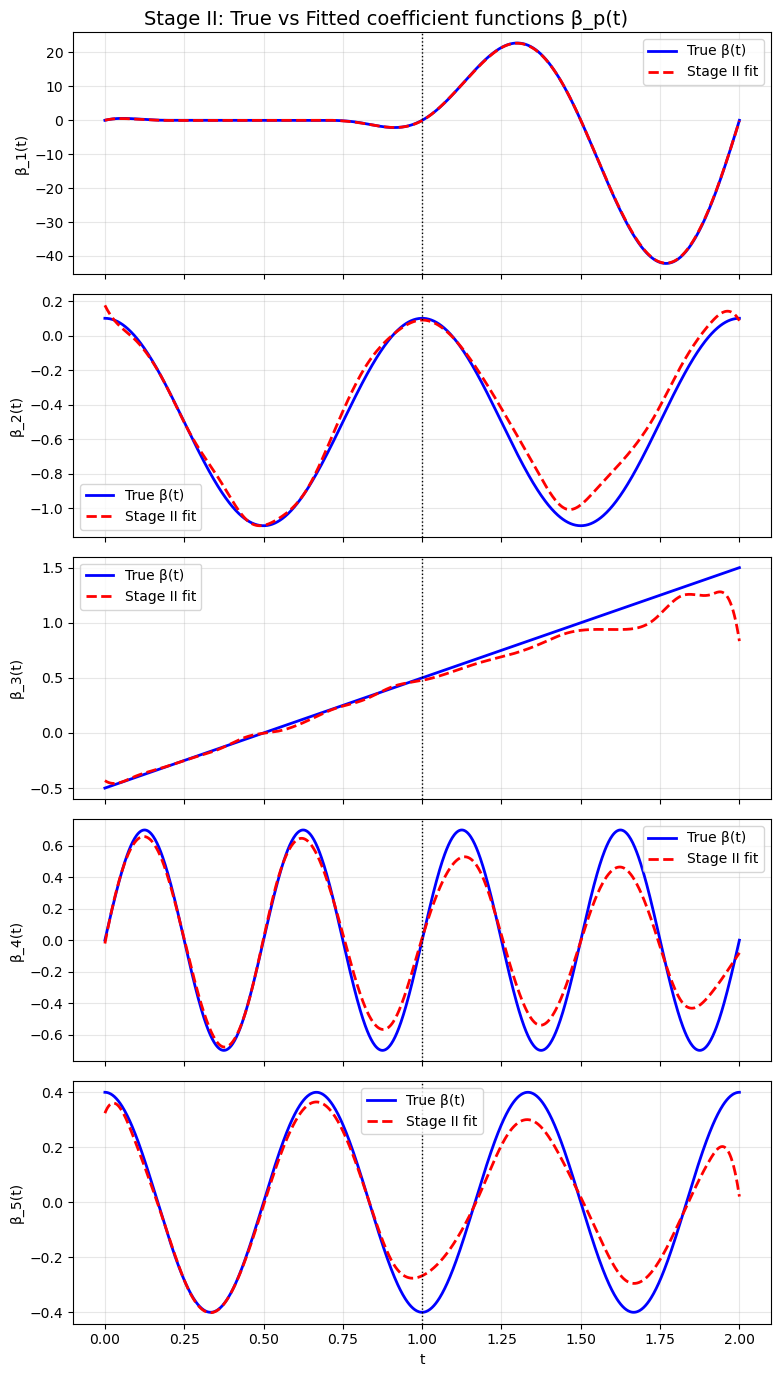

In [5]:
# ============================ 阶段 II 拟合 vs 真值 可视化 ============================

# ---------- 准备真值 ----------
# 重新生成理论真值 β_true(t)，用相同 true_funcs
funcs = true_funcs()
t_all_sorted = np.linspace(0, 2, 1000)
beta_true_all = np.zeros((len(t_all_sorted), P))
for j, idx in enumerate(signal_idx):
    beta_true_all[:, idx] = funcs[j % len(funcs)](t_all_sorted)

# ---------- 拟合值 ----------
B_eval = bspline_design_matrix(t_all_sorted, knots2, k)
betahat2_eval = np.column_stack([B_eval @ coef2[p] for p in range(P)])

# ---------- 可视化 ----------
r = min(len(signal_idx), 5)
fig, axs = plt.subplots(r, 1, figsize=(8, 2.2*r+3), sharex=True)

for ax, p in zip(axs, signal_idx[:r]):
    ax.plot(t_all_sorted, beta_true_all[:, p], 'b', lw=2, label='True β(t)')
    ax.plot(t_all_sorted, betahat2_eval[:, p], 'r--', lw=2, label='Stage II fit')
    ax.axvline(1, color='k', ls=':', lw=1)  # 阶段切换点
    ax.set_ylabel(f"β_{p}(t)")
    ax.legend(loc='best'); ax.grid(alpha=0.3)

axs[-1].set_xlabel("t")
fig.suptitle("Stage II: True vs Fitted coefficient functions β_p(t)", fontsize=14)
plt.tight_layout(); plt.show()
